Columns in order: ['stage_m', 'discharge_cms']
Training period: 1995-10-01 00:00:00 to 2018-04-20 00:00:00
Validation period: 2019-01-01 00:00:00 to 2025-06-01 00:00:00
Training samples: 8216 (77.8%)
Validation samples: 2344 (22.2%)
Gap between training and validation: 2019-01-01 - 2018-04-21
Scaler saved to 'multivariate_discharge_scaler.joblib'

New sequence shapes:
X_train shape: (8203, 7, 2)
y_train shape: (8203, 7)
Number of features being used: 2


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 7, 2)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_12 (LSTM)      │ (None, 7, 128)    │     67,072 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_13 (LSTM)      │ [(None, 128),     │    131,584 │ lstm_12[0][0]     │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_3     │ (None, 7, 128)    │          0 │ lstm_13[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_14 (LSTM)      │ (None, 7, 128)    │    131,584 │ repeat_vector_3[… │
│                     │                   │            │ lstm_13[0][1],    │
│                     │                   │            │ lstm_13[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_15 (LSTM)      │ (None, 7, 128)    │    131,584 │ lstm_14[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, 7, 1)      │        129 │ lstm_15[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 461,953 (1.76 MB)

 Trainable params: 461,953 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.7211 - val_loss: 0.6870
Epoch 2/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.5658 - val_loss: 0.6390
Epoch 3/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.5205 - val_loss: 0.5989
Epoch 4/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.5111 - val_loss: 0.6077
Epoch 5/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.5031 - val_loss: 0.5809
Epoch 6/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.4925 - val_loss: 0.5906
Epoch 7/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.5250 - val_loss: 0.5808
Epoch 8/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.4818 - val_loss: 0.5894
Epoch 9/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.4945 - val_loss: 0.5831
Epoch 10/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.4669 - val_loss: 0.5778
Epoch 11/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.4605 - val_loss: 0.6106
Epoch 12/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step

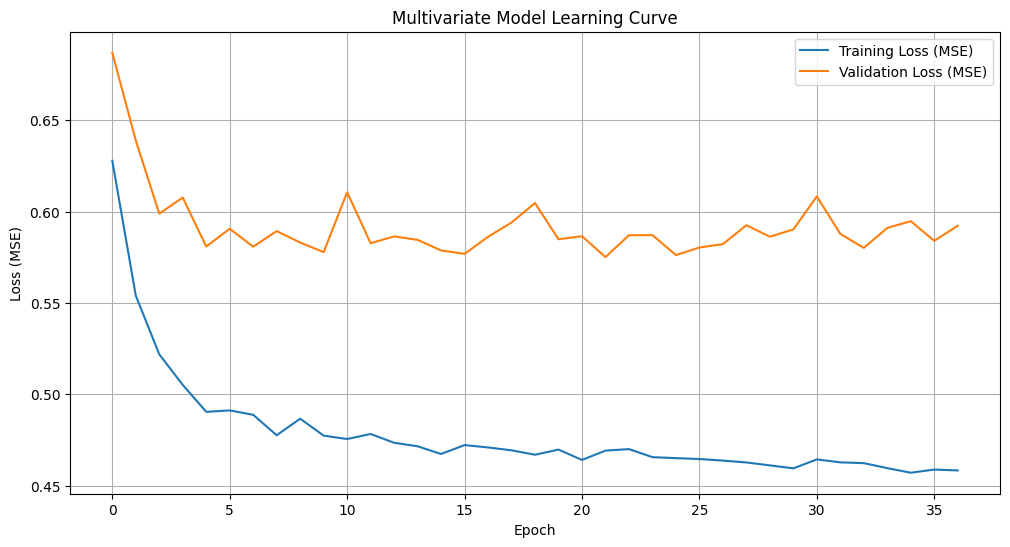

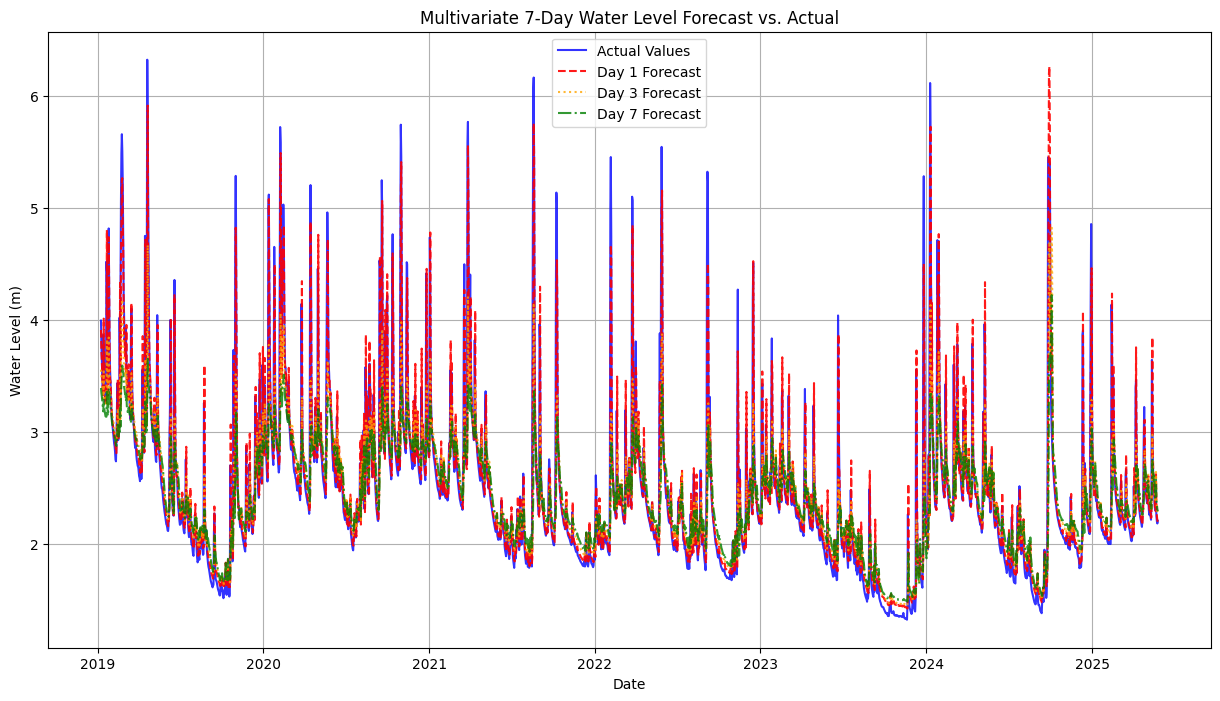

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import joblib

# 1. Load and Prepare Data: Use both 'stage_m' (target) and 'discharge_cms' (feature) as input features
df_multi = pd.read_csv('combined_dataset.csv', index_col='datetime', parse_dates=True)

# Only keep 'stage_m' and 'discharge_cms', with 'stage_m' as the first column
df_multi = df_multi[['stage_m', 'discharge_cms']]

print("Columns in order:", df_multi.columns.tolist())

# 2. Split Data with a Gap (Apply the same logic as in context7/univariate)
# Dataset: 1995-10-01 to 2025-06-01 (~29.67 years)
# Paper approach: 76% training, 23% validation with gap
# Training: 76% of 29.67 years ≈ 22.55 years → 1995-10-01 to 2018-04-21
# Gap: ~8 months (2018-04-21 to 2019-01-01)
# Validation: 2019-01-01 to 2025-06-01

split_date_train_end = '2018-04-21'
split_date_val_start = '2019-01-01'
train_data = df_multi.loc[df_multi.index < split_date_train_end]
val_data = df_multi.loc[df_multi.index >= split_date_val_start]

print(f"Training period: {train_data.index.min()} to {train_data.index.max()}")
print(f"Validation period: {val_data.index.min()} to {val_data.index.max()}")
print(f"Training samples: {len(train_data)} ({len(train_data)/(len(train_data)+len(val_data))*100:.1f}%)")
print(f"Validation samples: {len(val_data)} ({len(val_data)/(len(train_data)+len(val_data))*100:.1f}%)")
print(f"Gap between training and validation: {split_date_val_start} - {split_date_train_end}")

# 3. Scale Data
scaler = StandardScaler()
scaled_train_data = scaler.fit_transform(train_data)
scaled_val_data = scaler.transform(val_data)

# Save the fitted scaler using joblib
joblib.dump(scaler, 'multivariate_discharge_scaler.joblib')
print("Scaler saved to 'multivariate_discharge_scaler.joblib'")

# 4. Create Sequences (X: BOTH stage_m and discharge_cms, y: stage_m)
N_PAST = 7    # Use 7 days of history
N_FUTURE = 7  # Predict 7 days into the future

def create_sequences(data, n_past, n_future):
    X, y = [], []
    target_col_index = 0 # 'stage_m' is at index 0
    for i in range(n_past, len(data) - n_future + 1):
        # Input X: takes n_past days of BOTH features (shape: n_past, 2)
        X.append(data[i - n_past:i, :])
        # Output y: takes n_future days of ONLY the target feature
        y.append(data[i:i + n_future, target_col_index])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(scaled_train_data, N_PAST, N_FUTURE)
X_val, y_val = create_sequences(scaled_val_data, N_PAST, N_FUTURE)

print(f"\nNew sequence shapes:")
print(f"X_train shape: {X_train.shape}") # Should be (samples, 7, 2)
print(f"y_train shape: {y_train.shape}")   # Should be (samples, 7)

# 5. Build Stacked LSTM Encoder-Decoder (n_features = 2)
n_features = X_train.shape[2]
print(f"Number of features being used: {n_features}")
UNITS = 128
DROPOUT_RATE = 0.15

inputs = Input(shape=(N_PAST, n_features))
encoder_l1 = LSTM(UNITS, return_sequences=True, dropout=DROPOUT_RATE)(inputs)
encoder_l2, state_h, state_c = LSTM(UNITS, return_sequences=False, dropout=DROPOUT_RATE, return_state=True)(encoder_l1)
encoder_states = [state_h, state_c]
decoder_inputs = RepeatVector(N_FUTURE)(encoder_l2)
decoder_l1 = LSTM(UNITS, return_sequences=True, dropout=DROPOUT_RATE)(decoder_inputs, initial_state=encoder_states)
decoder_l2 = LSTM(UNITS, return_sequences=True, dropout=DROPOUT_RATE)(decoder_l1)
output = TimeDistributed(Dense(1))(decoder_l2)
model = Model(inputs=inputs, outputs=output)

# 6. Compile Model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.summary()

# 7. Train the Model
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='best_multivariate_discharge_model.keras', save_best_only=True, monitor='val_loss', mode='min')

history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=128,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

# 8. Evaluation and Visualization

# Load the scaler back (this demonstrates how you'd use it in production)
loaded_scaler = joblib.load('multivariate_discharge_scaler.joblib')

best_model = tf.keras.models.load_model('best_multivariate_discharge_model.keras')
predictions_scaled = best_model.predict(X_val).squeeze()

# --- Special handling for inverse scaling ---
# Create a dummy array shaped like the original data the scaler was fit on
# We will overwrite the first column (our target) with our predictions
dummy_preds = np.zeros((len(predictions_scaled.flatten()), 2))
dummy_preds[:, 0] = predictions_scaled.flatten()
# Inverse transform the entire dummy array
rescaled_preds = loaded_scaler.inverse_transform(dummy_preds)
# Extract just the first column (our rescaled predictions) and reshape
predictions_original = rescaled_preds[:, 0].reshape(y_val.shape)

# Do the same for the true values
dummy_true = np.zeros((len(y_val.flatten()), 2))
dummy_true[:, 0] = y_val.flatten()
rescaled_true = loaded_scaler.inverse_transform(dummy_true)
y_true_original = rescaled_true[:, 0].reshape(y_val.shape)
# --- End of special handling ---

print("\n--- MULTIVARIATE Model Performance on Validation Set ---")
for i in range(N_FUTURE):
    day = i + 1
    mae = mean_absolute_error(y_true_original[:, i], predictions_original[:, i])
    rmse = np.sqrt(mean_squared_error(y_true_original[:, i], predictions_original[:, i]))
    r2 = r2_score(y_true_original[:, i], predictions_original[:, i])
    print(f"Day {day} Ahead -> MAE: {mae:.4f} m, RMSE: {rmse:.4f} m, R²: {r2:.4f}")

# Plotting code remains the same
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.title('Multivariate Model Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

val_dates = val_data.index[N_PAST:len(y_true_original) + N_PAST]
plt.figure(figsize=(15, 8))
plt.plot(val_dates, y_true_original[:, 0], label='Actual Values', color='blue', alpha=0.8)
plt.plot(val_dates, predictions_original[:, 0], label='Day 1 Forecast', color='red', linestyle='--', alpha=0.9)
plt.plot(val_dates, predictions_original[:, 2], label='Day 3 Forecast', color='orange', linestyle=':', alpha=0.8)
plt.plot(val_dates, predictions_original[:, 6], label='Day 7 Forecast', color='green', linestyle='-.', alpha=0.8)
plt.title('Multivariate 7-Day Water Level Forecast vs. Actual')
plt.xlabel('Date')
plt.ylabel('Water Level (m)')
plt.legend()
plt.grid(True)
plt.show()